# preAyudantía 5: Analisis de Varianza y análisis de datos categóricos

<a target="_blank" href="https://colab.research.google.com/github/SysBioengLab/IIQ3402-Statistical-Design/blob/main/Ayudantias/preAyudantia5_ANOVA.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!pip install statsmodels
!pip install pingouin

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 12.3 MB/s eta 0:00:0031m14.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.9 MB/s eta 0:00:00


# ANOVA

Anova, o Análisis de varianza, es un test estadístico utilizado para evaluar si diferentes tratamientos de un experimento generan cambios con respecto a una media general entre tratamientos. Este test hace uso de dos tipos de varianza en la información: (1) la varianza entre grupos, capturada por la media de diferencias cuadráticas entre medias de tratamientos y una media general, y (2) la varianza dentro de grupos, capturada por la diferencia entre cada observación de un grupo y su media.

Posteriormente, este test genera una hipótesis en base a la razón de dichas métricas.

Utilizando el siguiente dataset sintético veremos como realizar un test anova en python. En específico utilizaremos el siguiente paquete: [ANOVA statsmodels](https://www.statsmodels.org/stable/anova.html)

In [2]:
from statsmodels.formula.api import ols
import scipy.stats as st
from statsmodels.stats.anova import anova_lm
import pandas as pd
import numpy as np
np.random.seed(42)
trat1 = st.norm.rvs(loc = 4.1, scale = 1, size = 30)
trat2 = st.norm.rvs(loc = 4.9, scale = 0.8, size = 30)
trat3 = st.norm.rvs(loc = 3.9, scale = 1.2, size = 30)

df = pd.DataFrame(columns = ['score', 'group'])
df['score'] = list(trat1) + list(trat2) + list(trat3)
df['group'] = ['trat1'] * 30 + ['trat2'] * 30 + ['trat3'] * 30

El test de anova puede ser interpretado como un modelo lineal de la siguiente forma.

Para un experimento con $a$ tratamientos, y $n$ observaciones por tratamiento.
$$
Y_{ij} = \mu + \tau_i + \epsilon_{ij} \begin{cases} i = 1,\ldots, a \\ j = 1,\ldots, n \end{cases}
$$

Donde $\tau_i$ es el parámetro por el cuál se realiza el test de hipótesis. Así, se plantea:
$$
\begin{align}
H_0&: \tau_1 = \tau_2 = \tau_3 = \ldots = \tau_a = 0\\
H_a&: \tau_i \neq 0 \text{ para al menos un i}
\end{align}
$$

También puede plantearse como:
$$
\begin{align}
H_0&: \mu_1 = \mu_2 = \mu_3 = \ldots = \mu_a\\
H_a&: \mu_i \neq \mu_j \text{ para al menos un i y j}
\end{align}
$$

Esto implica que el test de ANOVa busca decir si alguno de los tratamientos genera diferencias entre el resto.

Ahora, nosotros al plantearlo como un modelo lineal, nosotros buscamos el parámetro $\tau_i$ para cada tratamiento con tal de hacer este tipo de análisis (el como se encuentra dicho parámetro será visto en la unidad siguiente).

Con esto en mente, podemos empezar a entender la sintaxis que utiliza `statsmodels` a la hora de realizar un test de ANOVA.





En primer lugar, los modelos ANOVA que se entregan a statsmodels deben ser modelos lineales, que siguen el siguiente formato:

In [3]:
model = ols(formula = 'score~C(group)', data = df).fit()


En este caso `score` es nuestra variable objetivo ($y$ en el modelo anterior) y `group` son nuestros tratamientos. En este caso, cada variable de `group` es tratado como una categoría, lo cual se codifica por `C(group)`.

Así este modelo define una relación entre los puntajes `score` y las categorías en group `C(group)`. Notar que `~` en este caso puede entender como el signo `=`.

`.fit()` va a ajustar los datos y generar un modelo lineal. De esta forma, este modelo lineal ajustado puede ser interpretado por la función `anova_lm` para generar el análisis.

---

Referencia:
- https://www.statsmodels.org/stable/example_formulas.html
- https://www.statsmodels.org/stable/generated/statsmodels.stats.anova.anova_lm.html

Previo a cualquier análisis de ANOVA hay que evaluar los supuestos del test:
- Independencia
- Normalidad
- Homocedasticidad

En el caso de normalidad, se utiliza el test de Shapiro-Wilk, donde la hipótesis nula es que los datos provienen de una distribución normal, así, buscamos $p-values > \alpha$.

Por otro lado, para la homocedasticidad utlizamos el test de Levene cuya hipótesis nula es que los datos poseen la misma varianza, así que buscamos $p-values > \alpha$.

In [4]:
# Asumimos independencia
# normalidad: Test shapiro-wilk
for grop in df['group'].unique():
    mask_ = df['group'] == grop
    datos = df[mask_]
    print(f'Shapiro-Wilk p-value (grupo {grop})' ,st.shapiro(datos['score'])[1])

# homocedasticidad
print('Levene p-value', st.levene(*[df[df['group'] == grop]['score'] for grop in df['group'].unique()])[1])

Shapiro-Wilk p-value (grupo trat1) 0.6868054942917083
Shapiro-Wilk p-value (grupo trat2) 0.9129582559088101
Shapiro-Wilk p-value (grupo trat3) 0.3653736158125399
Levene p-value 0.12684768366312826


Tenemos que los datos son homocedasticos y son normales, así que procedemos con ANOVA.

In [5]:
anova_test = anova_lm(model)
anova_test

,df,sum_sq,mean_sq,F,PR(>F)
C(group),2.0,15.821291,7.910646,8.530947,0.000414
Residual,87.0,80.674059,0.927288,NaN,NaN


De la tabla que obtenemos de ANOVA podemos ver en la columna `df` los grados de libertad de los tratamientos $(a-1)$, y los grados de libertad del error -en este caso denominados residual- $a(n-1)$.

Luego en la columna `sum_sq` se encuentra la suma de cuadrados para los tratamientos $SS_{\text{treatment}}$ y la suma de cuadrados del error $SS_E$.

En la columna `mean_sq` se encuentra el promedio de la suma de cuadrados de los tratamientos $MS_{\text{treatment}}$ y el promedio de la suma de cuadrados del error $MS_E$.

Recordemos que:
$$
\begin{align}
MS_{\text{treatment}} &= \frac{SS_{\text{treatment}}}{a-1}\\
MS_E &= \frac{SS_E}{a(n-1)}
\end{align}
$$

Luego, en la columna F se encuentra el estadístico de prueba de la prueba ANOVA:
$$
f_0 = \frac{MS_{\text{treatment}}}{MS_E}
$$

Finalmente, el valor-p de este test se calcula por medio de la distribución F con $df1 = a-1$ y $df2 = a(n-1)$. Donde:
$$
p_{\text{val}} = P(x > f_0 ) = 1 - P(x \leq f_0)
$$
Donde podemos ver que $ P(x \leq f_0)$ es el cdf de la distrubición F con $df1 = a-1$ y $df2 = a(n-1)$.

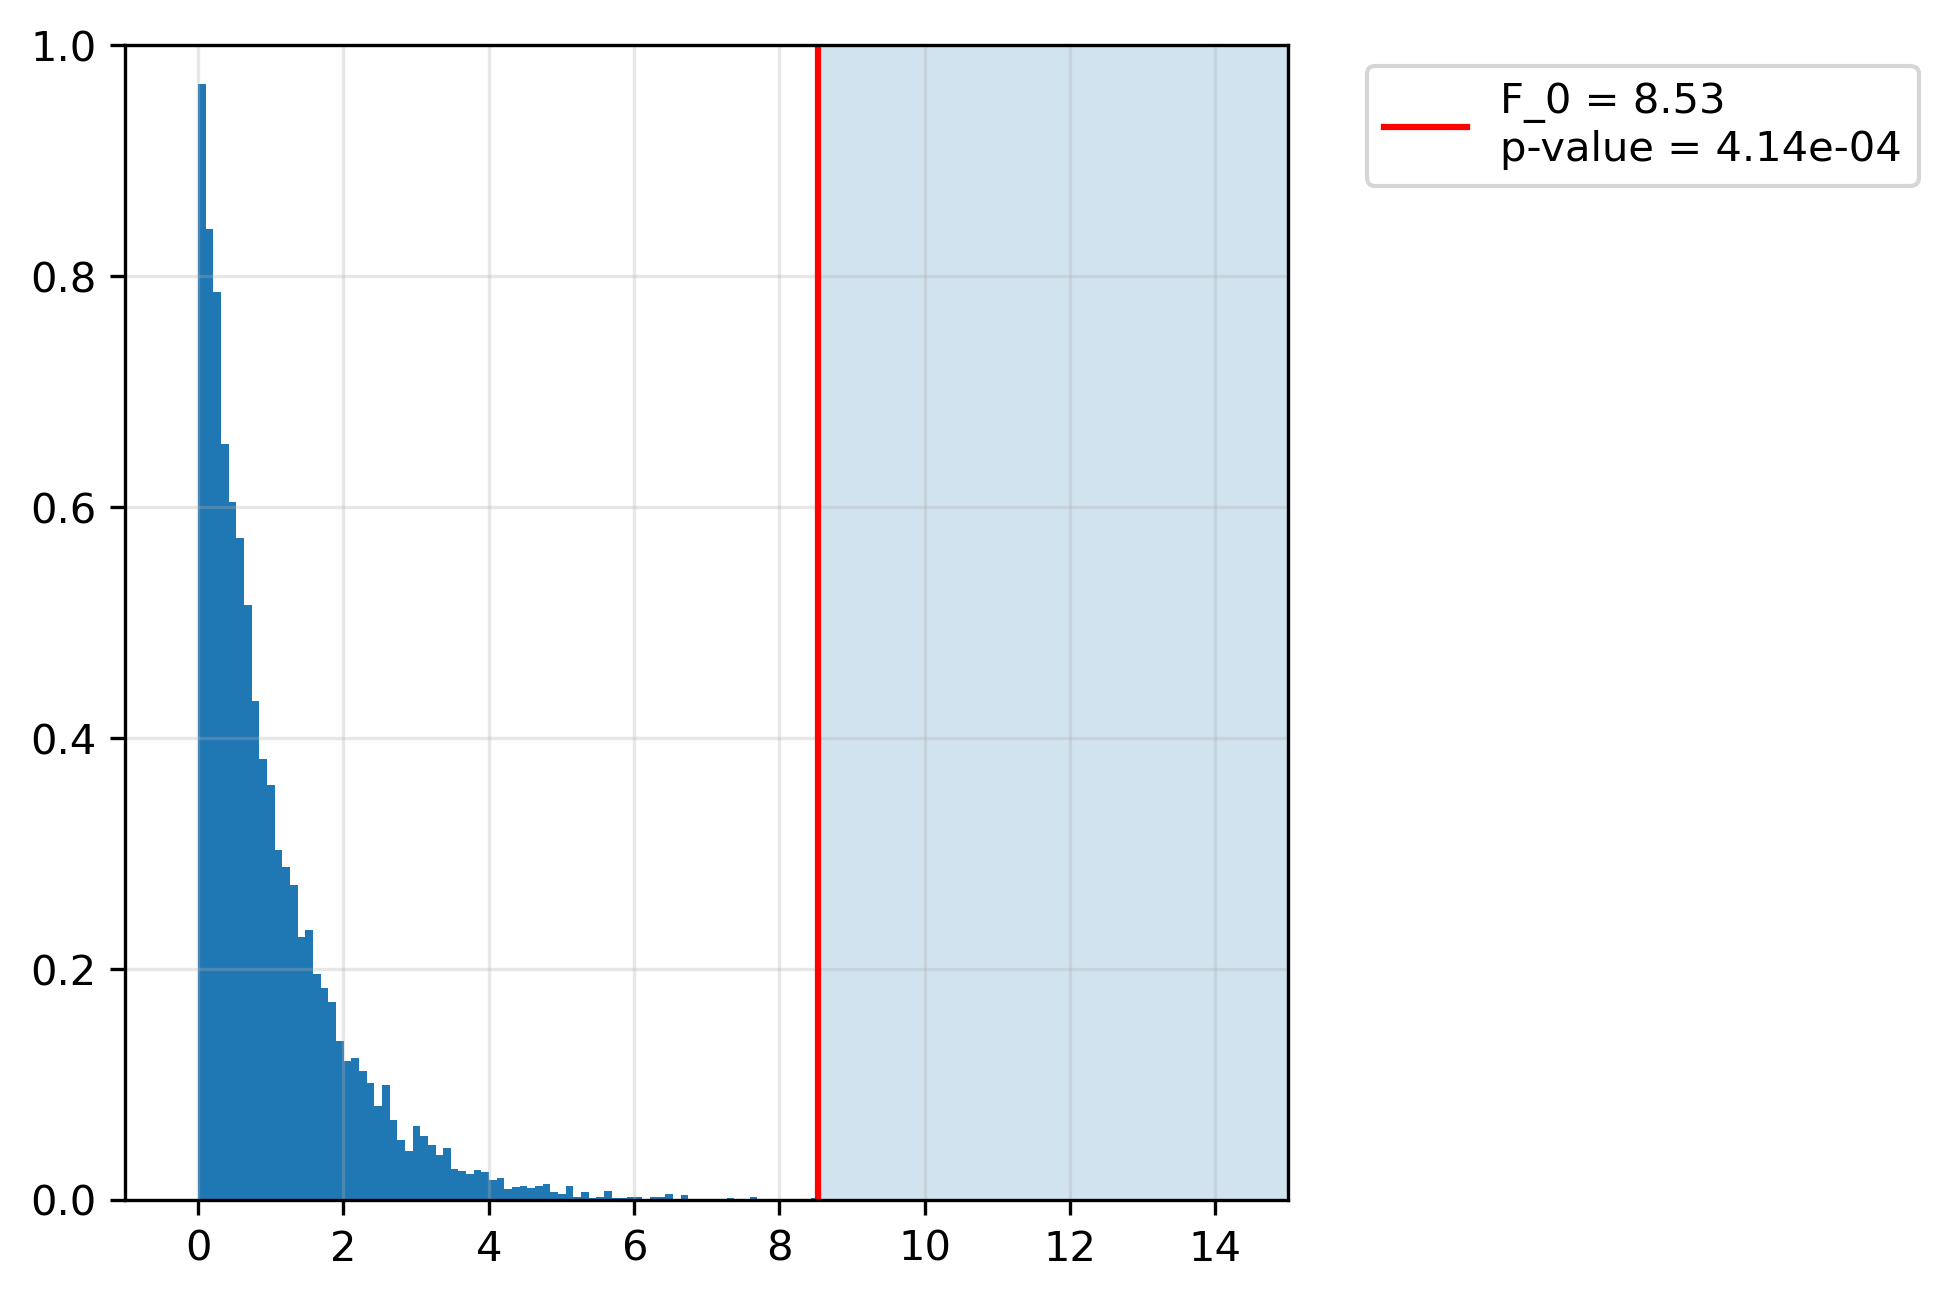

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(42)
f_dist = st.f.rvs(dfn = 2, # df1
                  dfd = 87, #df2
                  size = 10_000)
fig, ax = plt.subplots(dpi = 300, figsize= (5,5))

estadistico_f = anova_test['F'].iloc[0] # obtenemos el estadístico F
p_val = 1 - st.f.cdf(estadistico_f,
                     dfn = 2,
                     dfd = 87)
ax.hist(f_dist, bins = 'auto', density = True)
ax.axvline(x = estadistico_f, color = 'red', label = f'F_0 = {estadistico_f:.2f}\np-value = {p_val:.2e}')
ax.set_ylim(0, 1)
ax.fill_betweenx(y = ax.get_ylim(), x1 = estadistico_f, x2 = 15, alpha = 0.2)
ax.set_xlim(-1,15)
ax.grid(alpha = 0.3)
ax.legend(bbox_to_anchor = (1.05, 1), loc = 2)
plt.show()


# Análisis post-hoc

El análisis de ANOVA no permite sacar conclusiones sobre cual de los datos es más significativamente diferentes del resto. Por aquello, es necesario realizar test posteriores, post-hoc, para poder evaluar cuál presenta un mayor o menor efecto.



## Análisis sobre los residuos

En primera instancia, es siempre conveniente evaluar los residuos del modelo y verificar su normalidad.

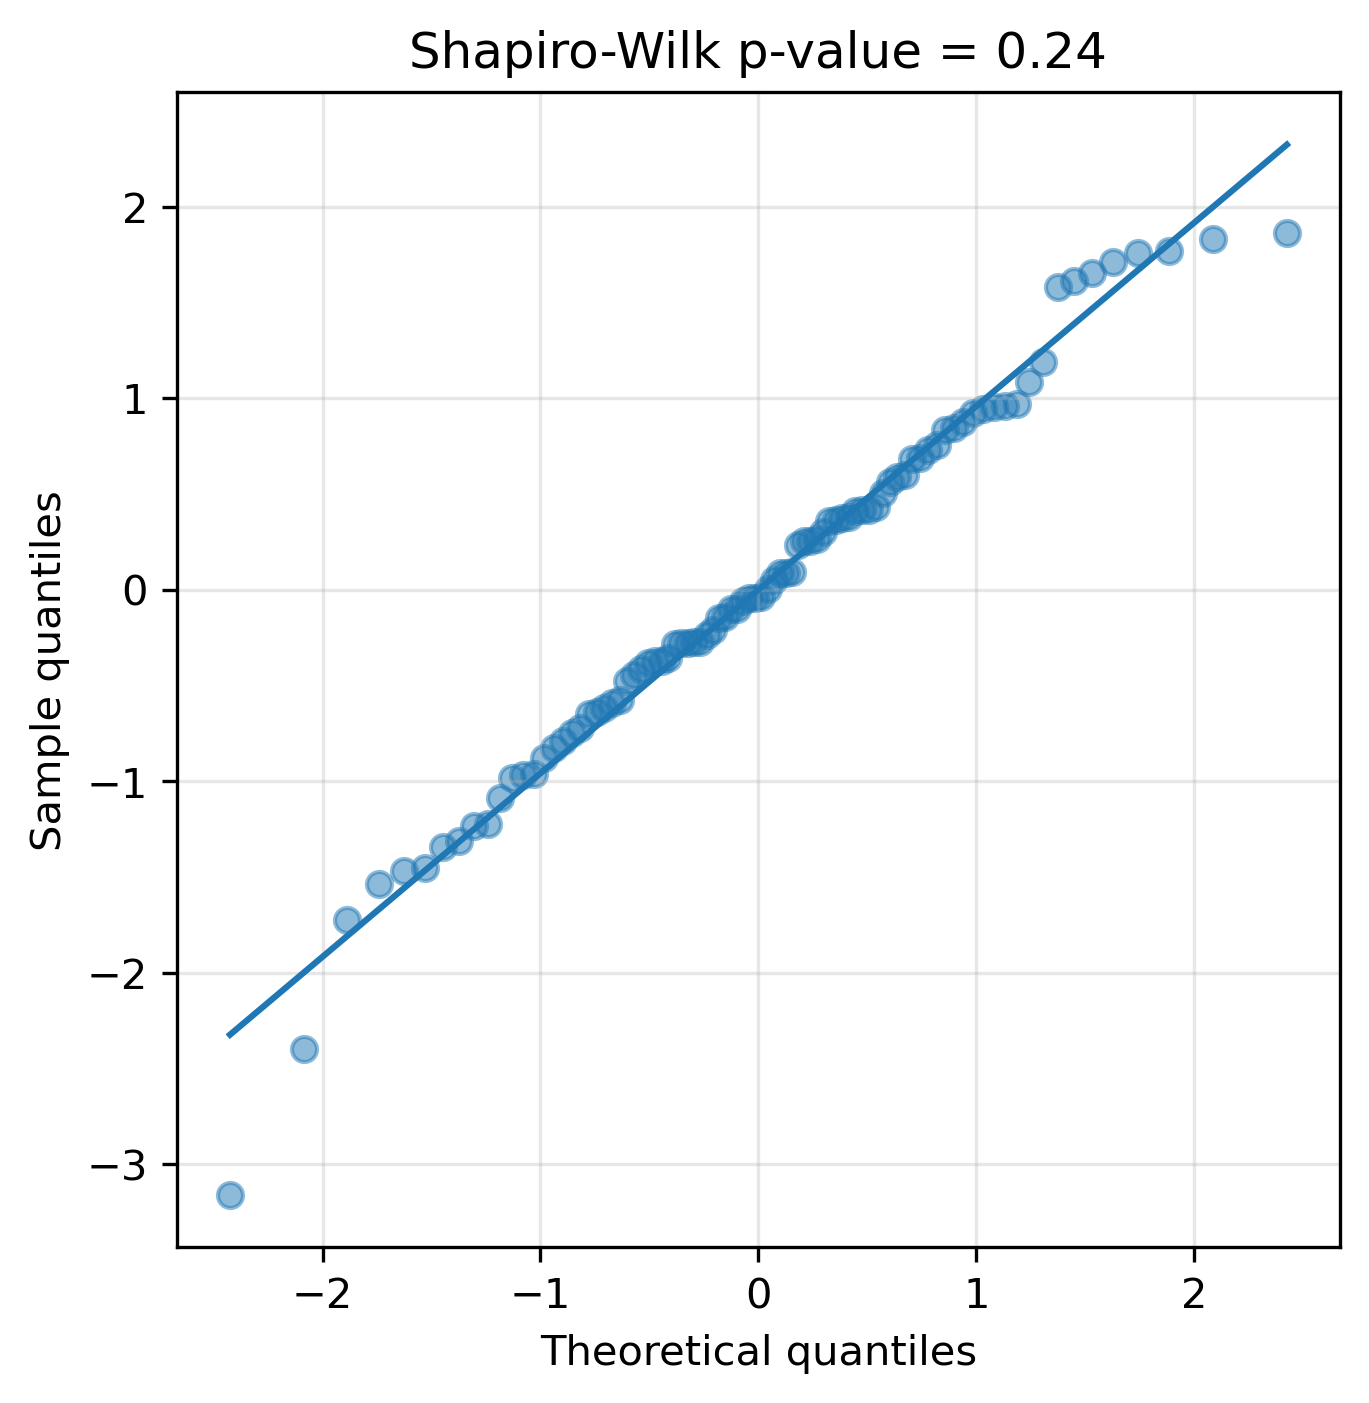

In [7]:
residuos = model.resid # obtenemos los residuos
(osm, osr), (slope, intercept, r) = st.probplot(residuos)
# qqplot
fig, ax = plt.subplots(dpi = 300, figsize = (5,5))
ax.scatter(osm, osr, alpha = 0.5)
shapiro_resid = st.shapiro(residuos)
ax.set_title(f'Shapiro-Wilk p-value = {shapiro_resid[1]:.2f}')
ax.plot(osm, osm*slope + intercept)
ax.set_xlabel('Theoretical quantiles')
ax.set_ylabel('Sample quantiles')
ax.grid(alpha = 0.3)
plt.show()

Entonces vemos que los residuos del modelo son normales. También es posible analizar los residuos del modelo con respecto a los factores del experimento.

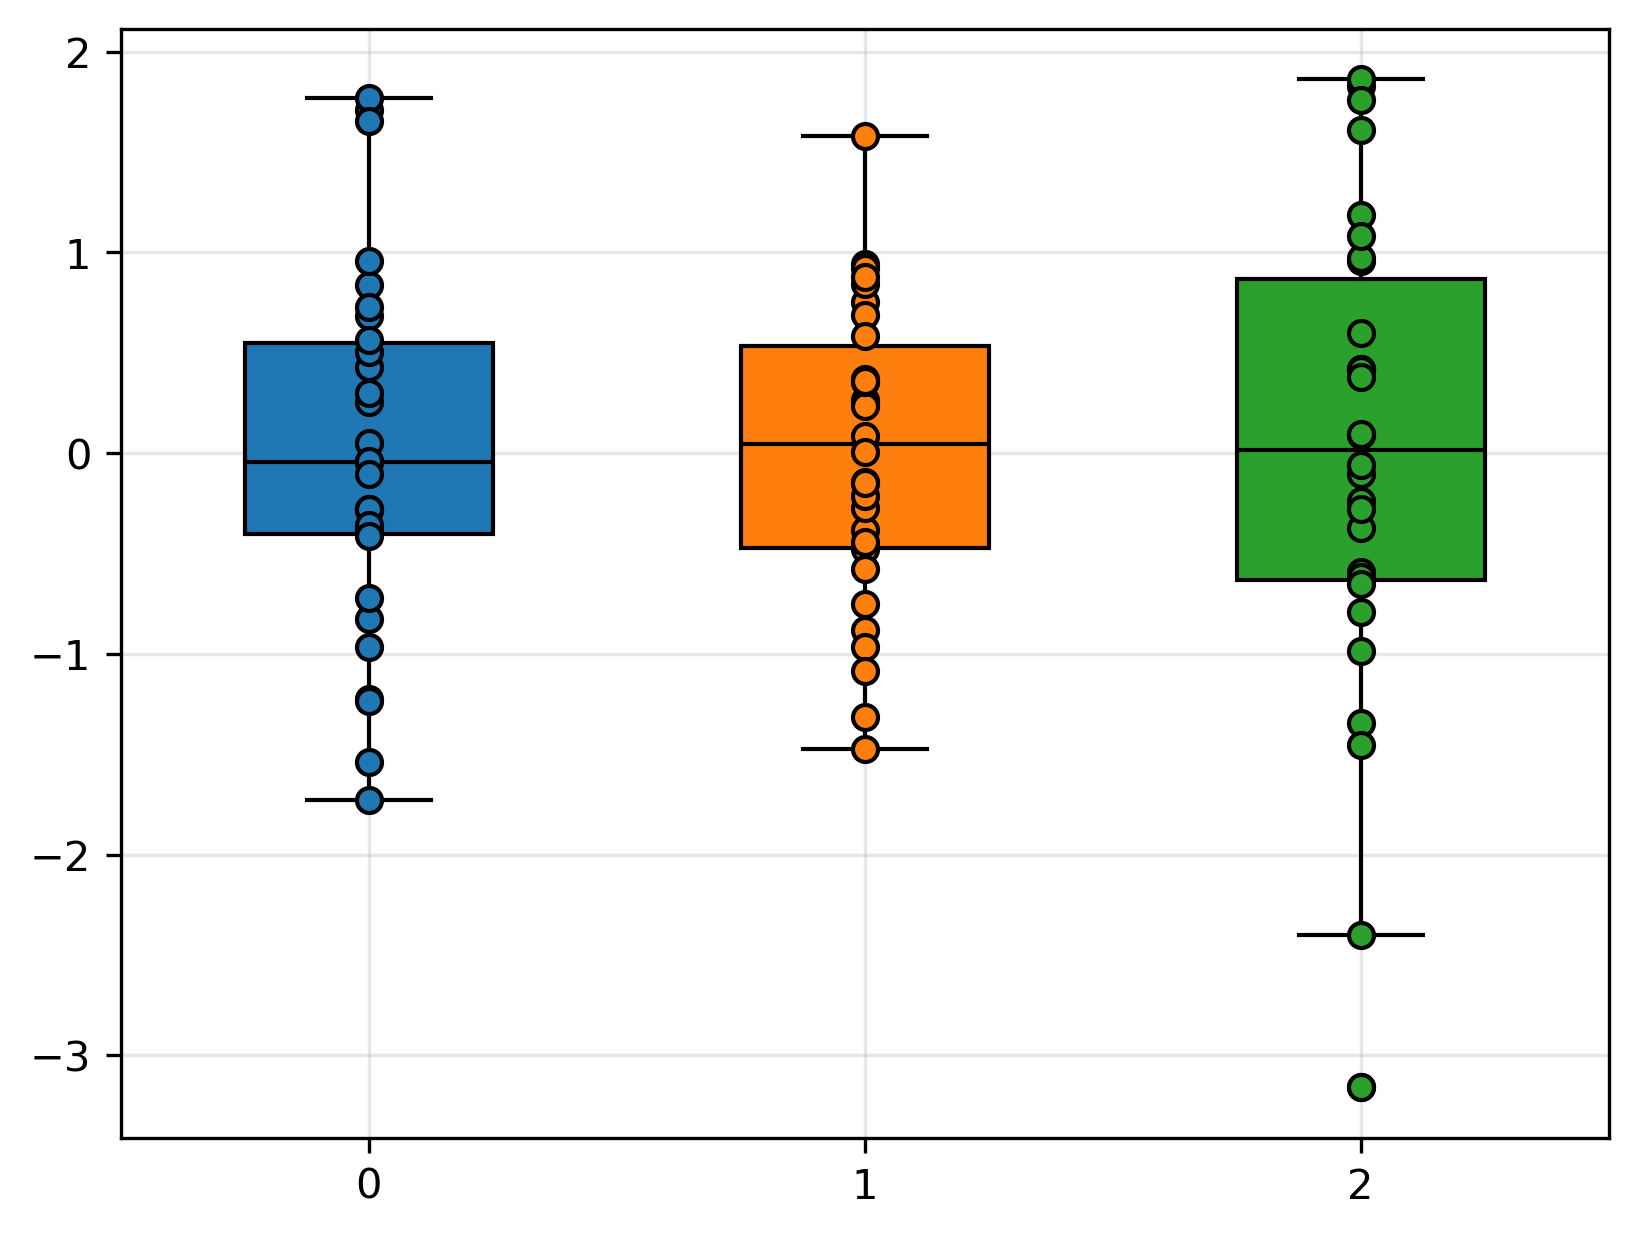

In [8]:
factores = pd.DataFrame(columns = ['score', 'group', 'residANOVA'])
factores['score'] = list(trat1) + list(trat2) + list(trat3)
factores['group'] = ['trat1'] * 30 + ['trat2'] * 30 + ['trat3'] * 30
factores['residANOVA'] = model.resid
fig, ax = plt.subplots(dpi = 300)
colors = ['tab:blue', 'tab:orange', 'tab:green']
for posi, g in enumerate(factores['group'].unique()):
    mask = factores['group'] == g
    ax.scatter([posi] * sum(mask),factores[mask]['residANOVA'], label = g, zorder = 3,
               color = colors[posi], edgecolor = 'k')
    ax.boxplot(
        factores[mask]['residANOVA'],
        positions = [posi],
        widths = 0.5,
        patch_artist = True,
        boxprops = dict(facecolor = colors[posi]),
        medianprops = dict(color = 'k')
    )
ax.grid(alpha = 0.3, zorder = 0)

Y los residuos también poseen un comportamiento estable y con varianza similar. Por lo cuál el análisis ANOVA es confianble.

## Test estadísticos posteriores

El test más clásico es realizar un t-test en pares, que realiza un test-t sobre los datos.

---
[ttest pairwise](https://pingouin-stats.org/build/html/generated/pingouin.pairwise_tests.html)

In [11]:
import pingouin as pg
#ttest

pg.pairwise_ttests(dv = 'score',
                   between = 'group',
                   data = df,
                   padjust = 'bonferroni',
                   effsize = 'cohen')

/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,group,trat1,trat2,False,True,-4.178303,58.0,two-sided,0.000100,0.000300,bonferroni,221.52,-1.078833
1,group,trat1,trat3,False,True,-0.013245,58.0,two-sided,0.989478,1.000000,bonferroni,0.262,-0.003420
2,group,trat2,trat3,False,True,3.462141,58.0,two-sided,0.001013,0.003039,bonferroni,30.613,0.893921


En esta tabla podemos ver las comparaciones de los datos. Lo más importante es ver el valor-p con la corrección de Bonferroni.

Otro test que se suele realizar es el test Tukey HSD

In [17]:
pg.pairwise_tukey(dv = 'score',
                    between = 'group',
                    data = df,
                    effsize = 'cohen')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,cohen
0,trat1,trat2,3.911853,4.803070,-0.891217,0.248635,-3.584443,0.001599,-1.078833
1,trat1,trat3,3.911853,3.915462,-0.003609,0.248635,-0.014514,0.999884,-0.003420
2,trat2,trat3,4.803070,3.915462,0.887608,0.248635,3.569930,0.001677,0.893921


<Axes: xlabel='group', ylabel='score'>

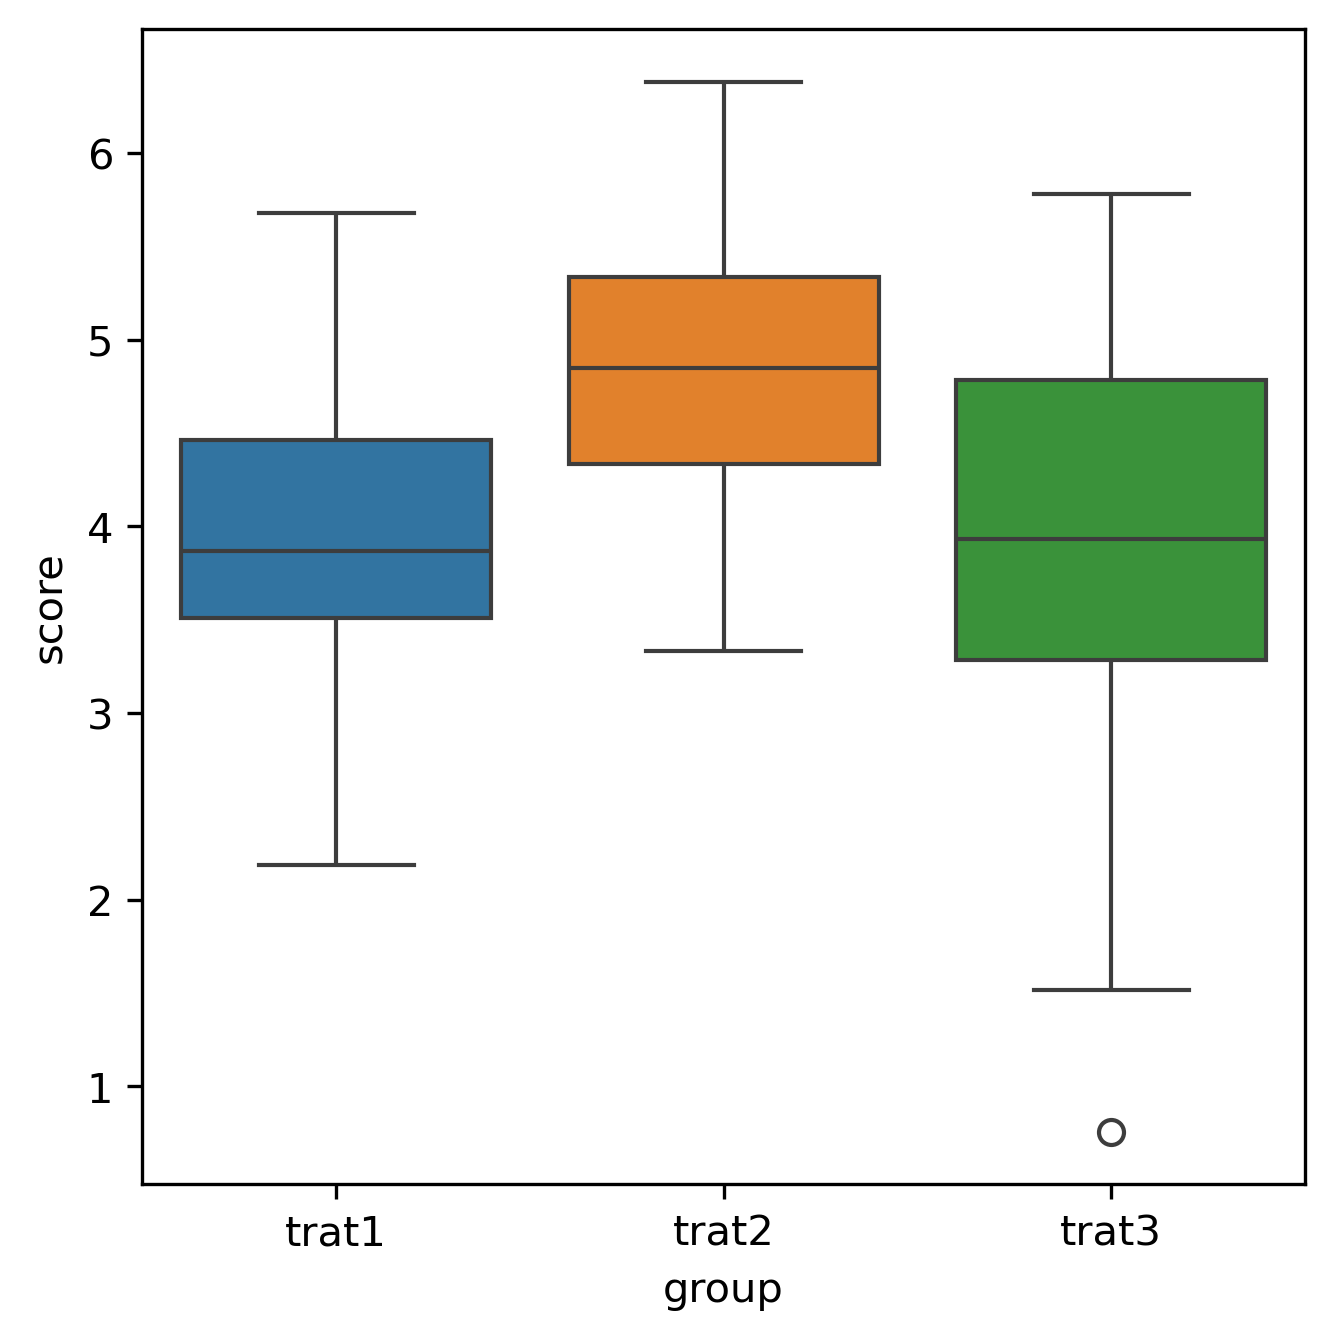

In [10]:
fig, ax = plt.subplots(dpi = 300, figsize = (5,5))
sns.boxplot(x = 'group', y = 'score', hue = 'group', data = factores, ax = ax)